# Building a Neural Network to recognize Quick Draw doodles

The general idea of this notebook will be to try and test the solutions provided by Google AI and other kagglers to the classification problem linked to the Quick Draw dataset.

## Google AI suggestion

Building a Neural Network dataset introducting LSTM layers. Indeed, they want to take into account the notion of temporality by using layers that keep track of what happened before. They also do not want to use a Neural Network that would consider the input as an image by using 1D Convolutionnal Layers. It's worth a try ! 

Tutorial of Google AI's solution in Tensorflow right here : https://www.tensorflow.org/tutorials/sequences/recurrent_quickdraw

## Considering the dataset as images only

A simpler idea would consist in interpreting the vectors of coordinates of the dataset as images only. Thus, we could use classical Neural Networks architectures that would consist in a succession of 2D Convolutionnal Layers and Max Pooling Layers, ending with a Flatten Layer then a FC layer.

Exemple of such a solution in Tensorflow here : https://www.kaggle.com/gaborfodor/black-white-cnn-lb-0-75/notebook

## Data Loading and Preprocessing

In [1]:
import pandas as pd 
import numpy as np 
import ast
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import glob

import torch
import torch.utils.data
import torchvision

In [2]:
train_size = 80
test_size = 20
total_size = train_size + test_size

In [3]:
path = '..\\data\\train_simplified' # use your path
allFiles = glob.glob(path + "\\*.csv")
frame = pd.DataFrame()
trainlist_ = []
testlist_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col='key_id',nrows=100).drop(['countrycode', 'recognized', 'timestamp'], axis=1)[:total_size]
    trainlist_.append(df[:train_size])
    testlist_.append(df[train_size:total_size])
data_train = pd.concat(trainlist_)
data_test = pd.concat(testlist_)

In [4]:
data_train.drawing = data_train.drawing.map(ast.literal_eval)
data_test.drawing = data_test.drawing.map(ast.literal_eval)

In [5]:
partition = {'train':data_train, 'test':data_test}

In [45]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data,  base_size = 255, size = None, lw = 6):
        'Initialization'
        self.lw = lw
        if size == None:
            self.size = base_size
        self.base_size = base_size
        self.data = data
        self.labels = data.word
        self.drawing = data.drawing

    def draw_cv2(self, raw_strokes):
        img = np.zeros((self.base_size, self.base_size), np.uint8)
        for stroke in raw_strokes:
            for i in range(len(stroke[0]) - 1):
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, self.lw)
        if self.size != self.base_size:
            return cv2.resize(img, (self.size, self.size))
        else:
            return img
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.drawing)

    def __getitem__(self, ind):
        'Generates one sample of data'
        # Select sample
        key_id = self.data.index[ind]

        # Load data and get label
        raw_strokes = self.data.drawing[key_id]
        X = torch.from_numpy(self.draw_cv2(raw_strokes))
        y = self.labels[key_id]

        return X, y

In [46]:
train_set = Dataset(partition['train'])
train_generator = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True)

test_set = Dataset(partition['test'])
test_generator = torch.utils.data.DataLoader(test_set,  batch_size=5, shuffle=True)

In [47]:
count = 1
for data in train_generator:
    if count == 1:
        inputs_try,labels_try = data
    count +=1

In [48]:
inputs_try[0].shape

torch.Size([255, 255])

Text(0.5,1,'anvil')

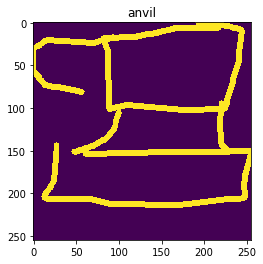

In [49]:
plt.imshow(inputs_try[0])
plt.title(labels_try[0])

In [50]:
model_conv = torchvision.models.resnet18(pretrained = False)

In [51]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
?F.avg_pool2d

In [52]:
class classifier(nn.Module):
    
    def __init__(self, pretrained_model):
        super(classifier, self).__init__()
        self.conv1 = nn.conv2d(in_channels=1, our_channels=64, kernel_size=3, stride=2, padding=3)
        self.pretrained_model = pretrained_model
        self.base = nn.Sequential(*list(pretrained_model.children())[:-1])
        self.linear = nn.Linear(in_features=512, out_features=340)
        
    def forward(self,x):
        x = self.base(x)
        x = F.avg_pool2d(x, x.size()[2:])
        f = x.view(x.size(0), -1)
        y = self.linear(f)
        return y


In [53]:
base_model = torchvision.models.resnet18(pretrained=False)

In [56]:
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [54]:
conv_class = classifier(base_model)

In [55]:
batch_3images = inputs_try.type(torch.FloatTensor)
conv_class(batch_3images)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got input of size [5, 255, 255] instead